<a href="https://colab.research.google.com/github/nueveonce/Etapa3DS/blob/main/Etapa3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto NLP: Análisis de Ofertas de Trabajo en LinkedIn

# Introduccion

## 1. Descripción del Problema de Negocio

Las empresas publican miles de ofertas de trabajo diariamente en plataformas como LinkedIn. Analizar manualmente estas descripciones para extraer información relevante (habilidades requeridas, tipo de contrato, sentimiento general de la oferta, etc.) es una tarea ardua y consume mucho tiempo. Existe la necesidad de automatizar este análisis para identificar tendencias del mercado laboral, optimizar la redacción de ofertas y facilitar a los candidatos la búsqueda de puestos adecuados.


# 2. Objetivo General
Aplicar técnicas de Procesamiento de Lenguaje Natural (NLP) para analizar y extraer información valiosa de las descripciones de puestos de trabajo publicados en LinkedIn. Específicamente, se buscará:
 * Preprocesar el texto de las descripciones.
 * Identificar las palabras y términos más frecuentes y significativos.
 * Analizar el sentimiento general expresado en las descripciones.
 * (Opcional Avanzado) Desarrollar un modelo de clasificación para predecir alguna característica de la oferta (ej. "seniority" inferida).

## 3. Origen de los Datos
El dataset proviene de LinkedIn y contiene información sobre ofertas de trabajo. La columna principal para el análisis NLP será 'description'.

In [29]:
# importacion de librerias
import pandas as pd
import re
import string
import nltk
nltk.download('punkt')
# Carga de datos
df = pd.read_csv('clean_jobs.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 4.Definición de las Variables:

id: Identificador único del trabajo (Numérico).
* title: Nombre del puesto de trabajo (Texto). Potencialmente útil para NLP, podría combinarse con 'description' o usarse para filtrar.
* company: Nombre de la empresa (Texto).
* location: Nombre del país del puesto de trabajo (Texto).
* link: URL de LinkedIn (Texto).
source: Siempre es LinkedIn (Texto).
* date_posted: Fecha de publicación del puesto de trabajo (Fecha/Texto). Podría usarse para análisis de tendencias temporales, pero no directamente para NLP del contenido.
* work_type: (NaN) - No disponible/Vacío.
* employment_type: (NaN) - No disponible/Vacío.
* description: Descripción del trabajo (Texto). Esta será la columna principal para el análisis NLP.

# 5.Librerias utilizadas

In [30]:
# Manipulación de datos
import pandas as pd
import numpy as np

# NLP
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Para lematización
from nltk.stem import PorterStemmer # Para stemming (opcional)
from nltk.util import ngrams
from collections import Counter

# Para TF-IDF y BoW, y Modelos de ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Análisis de Sentimiento
from textblob import TextBlob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Si se usa VADER para inglés

# Opcional: spaCy (alternativa robusta para NLP)
# import spacy
# # Cargar modelo de spaCy (ej. inglés o español)
# # !python -m spacy download en_core_web_sm # Para inglés
# # !python -m spacy download es_core_news_sm # Para español
# # nlp_spacy_en = spacy.load('en_core_web_sm')
# # nlp_spacy_es = spacy.load('es_core_news_sm')

# Configuraciones adicionales
# %matplotlib inline
# pd.set_option('display.max_colwidth', 200) # Para ver más texto en las celdas de pandas

# Descargar recursos de NLTK (ejecutar solo una vez si es necesario)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True) # Open Multilingual Wordnet

print("Librerías cargadas y recursos NLTK verificados.")

Librerías cargadas y recursos NLTK verificados.


# 6 Desarrollo

## 6.1. Lectura del documento

In [31]:
df.head(5)

,id,title,company,location,link,source,date_posted,work_type,employment_type,description
0,1,Data Analyst,Meta,"New York, NY",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
1,2,Data Analyst,Meta,"San Francisco, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
2,3,Data Analyst,Meta,"Los Angeles, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
3,4,Data Analyst,Meta,"Washington, DC",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
4,5,Data Analyst II,Pinterest,"Chicago, IL",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-16,NaN,NaN,About Pinterest\n\nMillions of people around t...


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               327 non-null    int64  
 1   title            327 non-null    object 
 2   company          327 non-null    object 
 3   location         327 non-null    object 
 4   link             327 non-null    object 
 5   source           327 non-null    object 
 6   date_posted      327 non-null    object 
 7   work_type        0 non-null      float64
 8   employment_type  0 non-null      float64
 9   description      327 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 25.7+ KB


### 6.1.1 Busqueda de valores nulos

In [33]:
df.isnull().sum()

,0
id,0
title,0
company,0
location,0
link,0
source,0
date_posted,0
work_type,327
employment_type,327
description,0


### 6.1.3 Eliminacion de velores nulos

In [34]:
# Se decide eliminar las columnas work_type y employment_type ya que no contienen valores en todo el dataset
df = df.drop(['work_type', 'employment_type'], axis=1)

## 6.2. Quitar simbolos y signos de puntuación

In [35]:


def limpiar_texto(texto):

    # Quitar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)

    # Quitar emails
    texto = re.sub(r'\S*@\S*\s?', '', texto)

    # Quitar saltos de línea y caracteres especiales (manteniendo espacios)
    texto = re.sub(r'\s+', ' ', texto) # Reemplazar múltiples espacios con uno solo
    texto = re.sub(r'(\r\n|\r|\n)', ' ', texto) # Reemplazar saltos de línea con espacio

    # Quitar caracteres que no sean alfanuméricos (excepto espacios)
    texto = re.sub(r'[^\w\s]', '', texto) # Esto quitaría también acentos
    # Una mejor aproximación es quitar solo la puntuación explícitamente
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # Quitar números si no son relevantes (opcional)
    texto = re.sub(r'\d+', '', texto)
    return texto.strip() # Eliminar espacios al inicio y al final

df['descripcion_limpia'] = df['description'].astype(str).apply(limpiar_texto)
print("\nEjemplo de descripción limpia:")
print(df['descripcion_limpia'].iloc[6])


Ejemplo de descripción limpia:
Netflix is one of the worlds leading entertainment services with  million paid memberships in over  countries enjoying TV series films and games across a wide variety of genres and languages Members can play pause and resume watching as much as they want anytime anywhere and can change their plans at any time Netflix is seeking a skilled and motivated Production Finance Tax and Vendor Data Analyst to join our team This role is pivotal in supporting our Production Finance teams with tasks related to Netflixs  Tax and Sustainability reporting The ideal candidate will have a strong skills in both data analysis and communication Responsibilities  Tax Analysis Data Pipeline Maintenance Monitor data pipelines to ensure continuous data flow for  tax forms ensuring data is flowing correctly and is available for analysis Data Modeling And Scripting Create and maintain SQL queries for data extraction analysis and reporting Focus on data consumption reconciliation 

In [36]:
# mostamos solo las columnas descripcion_limpia y description
df[['descripcion_limpia', 'description']].head(10)

,descripcion_limpia,description
0,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
1,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
2,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
3,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
4,About Pinterest Millions of people around the ...,About Pinterest\n\nMillions of people around t...
5,About Fanduel FanDuel Group is the premier mob...,About Fanduel\n\nFanDuel Group is the premier ...
6,Netflix is one of the worlds leading entertain...,Netflix is one of the world's leading entertai...
7,About Fanduel FanDuel Group is the premier mob...,About Fanduel\n\nFanDuel Group is the premier ...
8,Data Analyst Ecommerce Marketing Analytics Lo...,Data Analyst (Ecommerce & Marketing Analytics)...
9,About Pinterest Millions of people around the ...,About Pinterest\n\nMillions of people around t...


# Tokenizar
El propósito de la tokenización es dividir el texto en unidades significativas para construir un vocabulario que permita representar todas las palabras de manera única en una lista. Esta división es útil para análisis posteriores, como el etiquetado de partes del discurso (POS Tagging), donde se utiliza un paso de tokenizar el texto.

In [37]:
def descargar_recursos_nltk():
    recursos = ['punkt', 'punkt_tab', 'punkt-table', 'stopwords']  # Agrega otros que necesites
    for recurso in recursos:
        try:
            nltk.download(recurso)
        except:
            print(f"El recurso 😫 {recurso} no pudo ser descargado o ya existe")

descargar_recursos_nltk()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Error loading punkt-table: Package 'punkt-table' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def tokenizar_texto(texto):
    tokens = nltk.word_tokenize(texto, language='english' if any(c in 'áéíóúñ' for c in texto.lower()) else 'english')
    # Considerar el idioma de tus descripciones. Si son mayormente en inglés:
    # tokens = nltk.word_tokenize(texto, language='english')
    return tokens

df['tokens'] = df['descripcion_limpia'].apply(tokenizar_texto)
print("\nEjemplo de tokens:")
print(df['tokens'].iloc[0][:20]) # Mostrar los primeros 20 tokens


Ejemplo de tokens:
['The', 'Social', 'Measurement', 'team', 'is', 'a', 'growing', 'team', 'with', 'highvisibility', 'within', 'the', 'Communications', 'organization', 'that', 'is', 'being', 'tasked', 'with', 'measuring']


## 6.3. Convertir a minusculas

In [39]:
df['tokens_minusculas'] = df['tokens'].apply(lambda lista_tokens: [token.lower() for token in lista_tokens])

print("\nEjemplo de tokens en minúsculas (verificando):")
print(df['tokens_minusculas'].iloc[0][:20])



Ejemplo de tokens en minúsculas (verificando):
['the', 'social', 'measurement', 'team', 'is', 'a', 'growing', 'team', 'with', 'highvisibility', 'within', 'the', 'communications', 'organization', 'that', 'is', 'being', 'tasked', 'with', 'measuring']


## 6.4. Remoción de Stopwords

In [43]:
# Obtener stopwords en inglés
stop_words = set(stopwords.words('english'))
print(stop_words)

{'that', 'both', "you're", 'those', 'down', 'before', 'him', 'which', 'nor', 'wouldn', "wouldn't", 'if', 'theirs', 'further', 'more', 'a', 'ours', 'for', 'me', 'by', "you'd", 'i', 'themselves', "don't", "they'd", 'most', "we've", 'o', "i've", 'than', 'does', "isn't", "they've", 'into', 'don', 'they', 'now', "she'd", 'am', 'against', "they're", "wasn't", "couldn't", 'do', 'hadn', "haven't", "it'll", 'any', 'aren', 'yourself', "hasn't", 'll', 'itself', "mustn't", 'some', 'until', 'why', 'my', 'has', 'above', "won't", "shan't", 'only', "i'm", 'such', 'what', 'shan', 's', 'and', 'its', 'needn', "didn't", 'haven', "you'll", "needn't", 'there', 'an', 'or', 'out', 'once', 'too', 'whom', 'while', 're', 'd', 'few', 'these', 'mustn', "we'll", 'through', 'had', 'yours', 'after', 'have', "mightn't", "you've", 'ain', "it's", 'about', 'doing', 'didn', 'at', 'did', 'her', 'hasn', 'm', 'we', "we're", "we'd", 'doesn', 'is', 'myself', 'when', "she's", 'you', 'same', "that'll", 'not', 'off', 'was', 'just

In [53]:
def remover_stopwords(lista_tokens):
    tokens_filtrados = [token for token in lista_tokens if token.isalpha() and token not in stop_words and len(token) > 1]
    # token.isalpha() asegura que solo sean palabras (sin números o puntuación restante)
    # len(token) > 1 para quitar letras sueltas.
    return tokens_filtrados

df['tokens_sin_stopwords'] = df['tokens_minusculas'].apply(remover_stopwords)

print("\nEjemplo de tokens sin stopwords (primeros 20 de la primera descripción):")
print(df['tokens_sin_stopwords'].iloc[0][:20])


Ejemplo de tokens sin stopwords (primeros 20 de la primera descripción):
['social', 'measurement', 'team', 'growing', 'team', 'highvisibility', 'within', 'communications', 'organization', 'tasked', 'measuring', 'efficacy', 'impact', 'socialfirst', 'communications', 'marketing', 'efforts', 'youll', 'play', 'unique']


## 6.5. Lematización
La lematización es un proceso en el procesamiento del lenguaje natural (NLP) que consiste en reducir una palabra a su forma base o canónica, conocida como lema. Este proceso utiliza análisis morfológico y diccionarios para obtener la raíz válida de una palabra según su significado en el texto.

In [52]:
lemmatizer = WordNetLemmatizer()

def lematizar_tokens(lista_tokens):
    # Se asume que el idioma principal es inglés para WordNetLemmatizer.
    # El POS tag puede mejorar la lematización, pero para simplificar, no se usa aquí.
    tokens_lematizados = [lemmatizer.lemmatize(token) for token in lista_tokens]
    return tokens_lematizados

df['tokens_lematizados'] = df['tokens_sin_stopwords'].apply(lematizar_tokens)

print("\nEjemplo de tokens lematizados (primeros 20 de la primera descripción):")
print(df['tokens_lematizados'].iloc[0][:20])

# Crear una columna con el texto preprocesado final (lista de tokens unidos)
df['descripcion_procesada_final'] = df['tokens_lematizados'].apply(lambda tokens: " ".join(tokens))



Ejemplo de tokens lematizados (primeros 20 de la primera descripción):
['social', 'measurement', 'team', 'growing', 'team', 'highvisibility', 'within', 'communication', 'organization', 'tasked', 'measuring', 'efficacy', 'impact', 'socialfirst', 'communication', 'marketing', 'effort', 'youll', 'play', 'unique']


## 6.6. Nubes de palabras


Generando nube de palabras general...


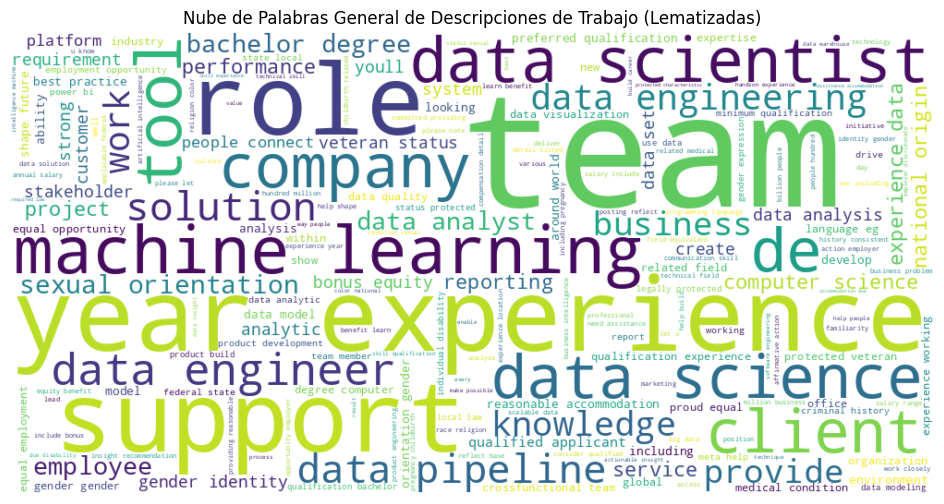

In [57]:
# Combinar todos los tokens lematizados en un solo texto largo
texto_completo_para_wordcloud = " ".join(df['descripcion_procesada_final'])

if texto_completo_para_wordcloud and len(texto_completo_para_wordcloud.split()) > 10: # Chequear que haya suficientes palabras
    print("\nGenerando nube de palabras general...")
    wordcloud_general = WordCloud(width=1000, height=500,
                                  background_color='white',
                                  colormap='viridis',
                                  max_words=200, # Mostrar las 200 palabras más frecuentes
                                  stopwords=None # Ya hemos quitado stopwords
                                 ).generate(texto_completo_para_wordcloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_general, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras General de Descripciones de Trabajo (Lematizadas)')
    plt.show()
else:
    print("No hay suficientes datos o palabras después del preprocesamiento para generar la nube de palabras general.")





Generando nube de palabras para 'Data Analyst'...


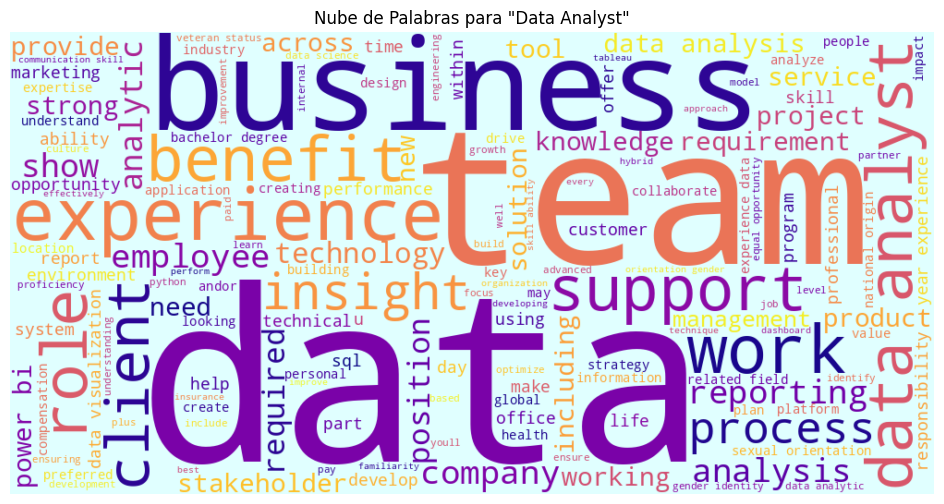

In [65]:
# Filtrar por título que contenga "Data Analyst" (case insensitive)
df_data_analyst = df[df["title"].str.contains("Data Analyst", case=False, na=False)]
if not df_data_analyst.empty:
    texto_data_analyst = " ".join(df_data_analyst['descripcion_procesada_final'])
    if texto_data_analyst and len(texto_data_analyst.split()) > 10:
        print("\nGenerando nube de palabras para 'Data Analyst'...")
        wordcloud_da = WordCloud(width=1000, height=500, background_color='lightcyan', colormap='plasma', max_words=150).generate(texto_data_analyst)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_da, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nube de Palabras para "Data Analyst"')
        plt.show()
    else:
        print("No hay suficientes datos o palabras para la nube de 'Data Analyst'.")
else:
    print("No se encontraron trabajos con el título 'Data Analyst' para generar una nube de palabras específica.")



Generando nube de palabras para 'Data Analyst'...


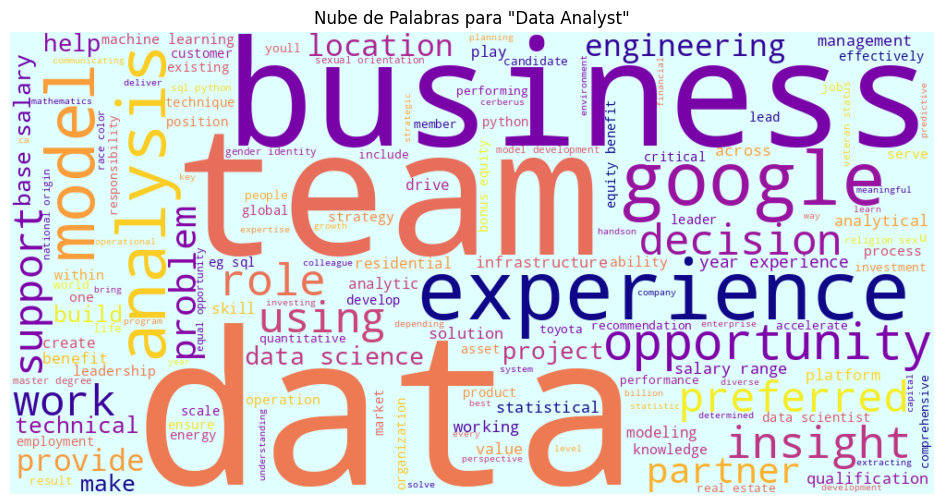

In [66]:
# Filtrar por título que contenga "Data Analyst" (case insensitive)
df_data_analyst = df[df["title"].str.contains("Data Science", case=False, na=False)]
if not df_data_analyst.empty:
    texto_data_analyst = " ".join(df_data_analyst['descripcion_procesada_final'])
    if texto_data_analyst and len(texto_data_analyst.split()) > 10:
        print("\nGenerando nube de palabras para 'Data Analyst'...")
        wordcloud_da = WordCloud(width=1000, height=500, background_color='lightcyan', colormap='plasma', max_words=150).generate(texto_data_analyst)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_da, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nube de Palabras para "Data Analyst"')
        plt.show()
    else:
        print("No hay suficientes datos o palabras para la nube de 'Data Analyst'.")
else:
    print("No se encontraron trabajos con el título 'Data Analyst' para generar una nube de palabras específica.")

## 6.7. N-Gramas


Top 15 Bigramas más comunes:
year experience: 284
machine learning: 257
data scientist: 233
data science: 215
data engineer: 202
data pipeline: 197
data engineering: 188
sexual orientation: 165
bachelor degree: 162
data analyst: 155
computer science: 154
experience data: 153
national origin: 149
gender identity: 147
data set: 145

Top 15 Trigramas más comunes:
sexual orientation gender: 111
degree computer science: 93
gender gender identity: 90
equal employment opportunity: 86
protected veteran status: 86
federal state local: 85
orientation gender gender: 80
gender identity gender: 79
identity gender expression: 79
state local law: 79
qualification bachelor degree: 79
consider qualified applicant: 77
let u know: 77
criminal history consistent: 76
bonus equity benefit: 76


<ipython-input-67-c745c801a03d>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_bigrams_df, x='Frequency', y='Ngram', palette='magma')


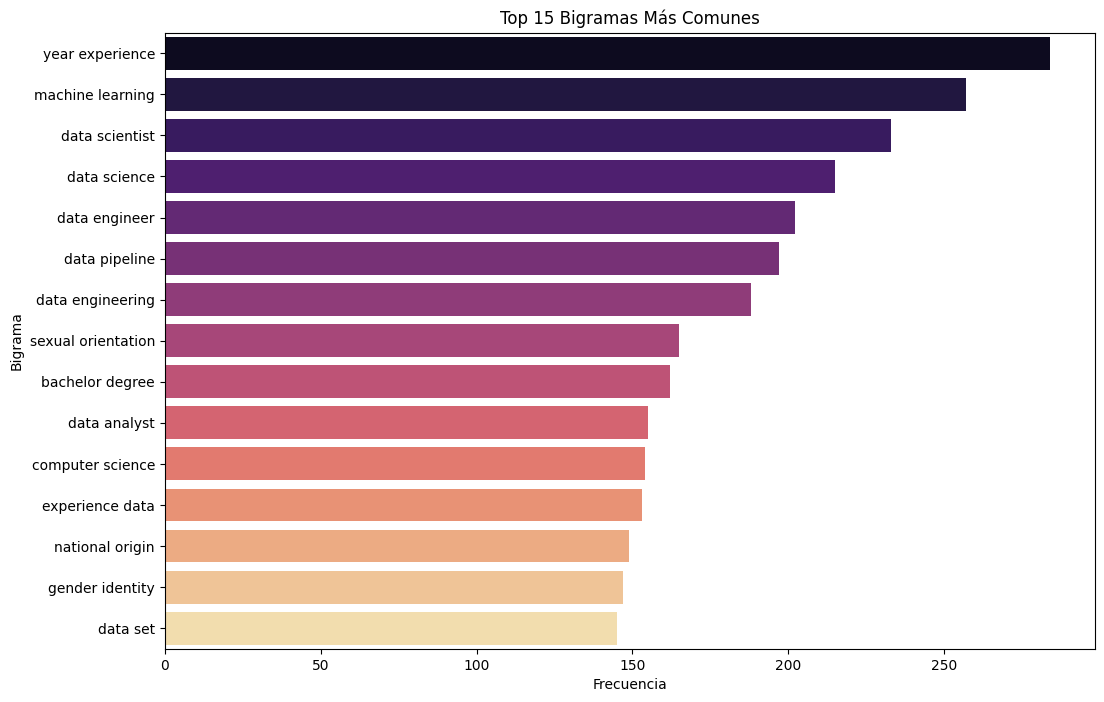

In [67]:
# Concatenar todos los tokens lematizados en una sola lista grande
todos_los_tokens_lematizados = [token for sublist in df['tokens_lematizados'] for token in sublist]

if len(todos_los_tokens_lematizados) > 1: # Necesita al menos 2 tokens para bigramas
    # Bigramas
    bigramas = list(ngrams(todos_los_tokens_lematizados, 2))
    frecuencia_bigramas = Counter(bigramas)
    print("\nTop 15 Bigramas más comunes:")
    common_bigrams = frecuencia_bigramas.most_common(15)
    for bigram, freq in common_bigrams:
        print(f"{' '.join(bigram)}: {freq}")

    # Trigramas
    if len(todos_los_tokens_lematizados) > 2: # Necesita al menos 3 tokens para trigramas
        trigramas = list(ngrams(todos_los_tokens_lematizados, 3))
        frecuencia_trigramas = Counter(trigramas)
        print("\nTop 15 Trigramas más comunes:")
        common_trigrams = frecuencia_trigramas.most_common(15)
        for trigram, freq in common_trigrams:
            print(f"{' '.join(trigram)}: {freq}")

        # Visualización de N-gramas (ejemplo con bigramas)
        if common_bigrams:
            common_bigrams_df = pd.DataFrame(common_bigrams, columns=['Ngram', 'Frequency'])
            common_bigrams_df['Ngram'] = common_bigrams_df['Ngram'].apply(lambda x: ' '.join(x)) # Convertir tupla a string

            plt.figure(figsize=(12, 8))
            sns.barplot(data=common_bigrams_df, x='Frequency', y='Ngram', palette='magma')
            plt.title('Top 15 Bigramas Más Comunes')
            plt.xlabel('Frecuencia')
            plt.ylabel('Bigrama')
            plt.show()
    else:
        print("No hay suficientes tokens para generar trigramas.")
else:
    print("No hay suficientes tokens para generar N-gramas.")


## 6.8. Análisis de Sentimientos


Estadísticas descriptivas del puntaje de sentimiento (TextBlob):
count    327.000000
mean       0.152864
std        0.102848
min       -0.800000
25%        0.090678
50%        0.153405
75%        0.207346
max        0.544444
Name: sentimiento_polaridad, dtype: float64

Distribución de las etiquetas de sentimiento:
sentimiento_label
positivo    87.155963
neutral     11.926606
negativo     0.917431
Name: proportion, dtype: float64


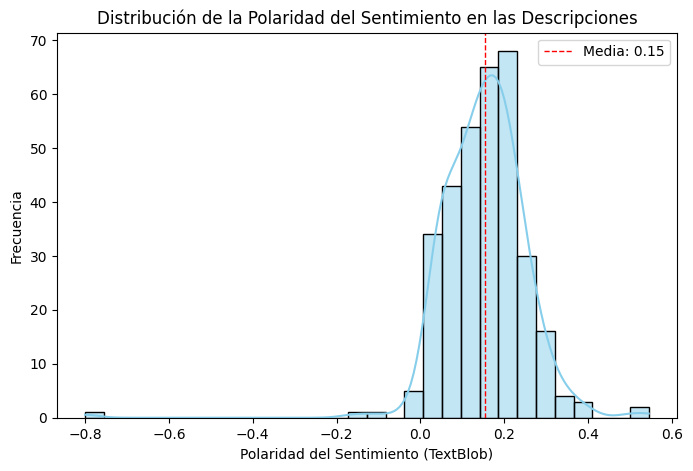

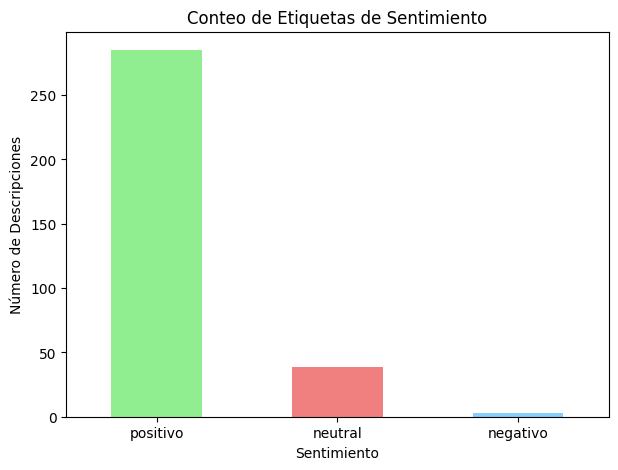

In [68]:
# Usaremos TextBlob, que es simple de usar. Recordar que su precisión es mejor en inglés.

def analizar_sentimiento_textblob(texto):
    # TextBlob intentará detectar el idioma, pero su análisis de sentimiento es más robusto para inglés.
    # Devuelve la polaridad: -1 (negativo) a 1 (positivo)
    try:
        analysis = TextBlob(texto)
        return analysis.sentiment.polarity
    except Exception as e:
        # print(f"Error analizando sentimiento para texto: {texto[:50]}... Error: {e}")
        return 0.0 # Retornar neutral en caso de error

df['sentimiento_polaridad'] = df['descripcion_procesada_final'].apply(analizar_sentimiento_textblob)

print("\nEstadísticas descriptivas del puntaje de sentimiento (TextBlob):")
print(df['sentimiento_polaridad'].describe())

# Convertir polaridad a etiquetas de sentimiento
def categorizar_sentimiento(polaridad, umbral_pos=0.05, umbral_neg=-0.05):
    if polaridad > umbral_pos:
        return 'positivo'
    elif polaridad < umbral_neg:
        return 'negativo'
    else:
        return 'neutral'

df['sentimiento_label'] = df['sentimiento_polaridad'].apply(categorizar_sentimiento)

print("\nDistribución de las etiquetas de sentimiento:")
print(df['sentimiento_label'].value_counts(normalize=True) * 100)

# Visualizar la distribución del sentimiento
plt.figure(figsize=(8, 5))
sns.histplot(df['sentimiento_polaridad'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de la Polaridad del Sentimiento en las Descripciones')
plt.xlabel('Polaridad del Sentimiento (TextBlob)')
plt.ylabel('Frecuencia')
plt.axvline(df['sentimiento_polaridad'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Media: {df['sentimiento_polaridad'].mean():.2f}")
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
df['sentimiento_label'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Conteo de Etiquetas de Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Descripciones')
plt.xticks(rotation=0)
plt.show()


# *Insight sobre Sentimiento:* Las descripciones de trabajo suelen ser formales e informativas, por lo que es común encontrar una mayoría de textos "neutrales". Un análisis más profundo podría implicar buscar un lenguaje excesivamente positivo (que podría indicar una cultura "vendehumo") o negativo (condiciones muy estrictas o poco atractivas).
